<a href="https://colab.research.google.com/github/matiqiu/mcd-scanveg-ai-model-experiments/blob/main/Exp04_Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Importaciones y configuración inicial
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import shutil
import pandas as pd
from google.colab import files
from itertools import cycle

# --- MEJORA: Fijar semillas para reproducibilidad ---
np.random.seed(42)
tf.random.set_seed(42)

# --- MEJORA: Verificar si la GPU está disponible ---
print("Versión de TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Habilitar crecimiento de memoria para evitar errores de OOM
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU detectada: {len(gpus)} dispositivo(s) encontrado(s).")
    except RuntimeError as e:
        print("❌ Error al configurar la GPU:", e)
else:
    print("⚠️ No se detectó ninguna GPU. El entrenamiento se ejecutará en la CPU y será lento.")


# Montar Google Drive para acceder a los modelos guardados y guardar los nuevos resultados
from google.colab import drive
drive.mount('/content/drive')

Versión de TensorFlow: 2.19.0
⚠️ No se detectó ninguna GPU. El entrenamiento se ejecutará en la CPU y será lento.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Autenticación de Kaggle y Descarga del Dataset

# --- MEJORA: Verificar si el dataset ya existe antes de descargar ---
dataset_path = '/content/PlantVillage'

if os.path.exists(dataset_path):
    print(f"✅ El dataset ya existe en la ruta: {dataset_path}")
else:
    print("Dataset no encontrado. Iniciando descarga desde Kaggle...")
    # Subir el token de Kaggle
    try:
        files.upload()
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Token de Kaggle configurado.")

        # Descargar y descomprimir el dataset
        !kaggle datasets download -d emmarex/plantdisease
        !unzip -q plantdisease.zip
        print("✅ Dataset descargado y descomprimido.")

    except (FileNotFoundError, KeyboardInterrupt):
        print("\n❌ Operación cancelada por el usuario. No se pudo descargar el dataset.")
        print("Si el dataset ya está en el entorno, puedes continuar. De lo contrario, ejecuta esta celda de nuevo.")

Dataset no encontrado. Iniciando descarga desde Kaggle...


Saving kaggle.json to kaggle.json
Token de Kaggle configurado.
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
100% 656M/658M [00:02<00:00, 283MB/s]
100% 658M/658M [00:02<00:00, 332MB/s]
✅ Dataset descargado y descomprimido.


In [ ]:
# 3. Configuración del Experimento y Preparación de Datos

# --- Parámetros del Experimento ---
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/PROYECTO'
EXPERIMENT_NAME = "exp04_custom_cnn"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 14  # <--- Ajustado a 14 épocas

# --- Preparación de Carpetas ---
src_dir = '/content/PlantVillage'
dst_dir = '/content/tomate_10clases'
tomato_classes = [
    'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
    'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

os.makedirs(dst_dir, exist_ok=True)
for cls in tomato_classes:
    src_cls_path = os.path.join(src_dir, cls)
    if os.path.isdir(src_cls_path):
        shutil.copytree(src_cls_path, os.path.join(dst_dir, cls), dirs_exist_ok=True)
print(f"Carpetas de {len(tomato_classes)} clases de tomate listas en: {dst_dir}")

# --- Generadores de Datos ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Carpetas de 10 clases de tomate listas en: /content/tomate_10clases
Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [ ]:
# 4. Construcción y Entrenamiento del Modelo (Experimento 4)

# --- Definir la arquitectura ---
# (La definición del modelo no cambia, se omite por brevedad)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- MEJORA: Lógica para reanudar el entrenamiento ---
model_path = f'{DRIVE_PROJECT_PATH}/{EXPERIMENT_NAME}.keras'
history_path = f'{DRIVE_PROJECT_PATH}/{EXPERIMENT_NAME}_history.pkl'
initial_epoch = 0
history_data = {}

# Verificar si ya existe un modelo y un historial para reanudar
if os.path.exists(model_path) and os.path.exists(history_path):
    print("🔄 Cargando punto de control anterior...")
    model = load_model(model_path)
    with open(history_path, 'rb') as f:
        history_data = pickle.load(f)
    initial_epoch = len(history_data.get('loss', [])) # Usar .get para evitar errores si la clave no existe
    print(f"El entrenamiento anterior se detuvo en la época: {initial_epoch}")
else:
    print("▶️ Iniciando un nuevo entrenamiento.")

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')
]

# --- Iniciar o reanudar el entrenamiento (SOLO SI ES NECESARIO) ---
if initial_epoch < EPOCHS:
    print(f"Continuando entrenamiento desde la época {initial_epoch} hasta la {EPOCHS}...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        initial_epoch=initial_epoch,
        callbacks=callbacks
    )

    # --- Actualizar y Guardar Historial ---
    # Si se reanudó, combinar historiales
    if initial_epoch > 0:
        for key in history_data.keys():
            history_data[key].extend(history.history[key])
        final_history = history_data
    else:
        final_history = history.history

    with open(history_path, 'wb') as f:
        pickle.dump(final_history, f)
    print(f"\n✅ Historial de entrenamiento actualizado y guardado.")

else:
    print("\n✅ El entrenamiento ya se había completado anteriormente. No se requiere entrenamiento adicional.")
    final_history = history_data # Usamos el historial ya cargado

print(f"Modelo final listo en: {model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,050 (433.79 KB)

 Trainable params: 111,050 (433.79 KB)

 Non-trainable params: 0 (0.00 B)

🔄 Cargando punto de control anterior...
El entrenamiento anterior se detuvo en la época: 14

✅ El entrenamiento ya se había completado anteriormente. No se requiere entrenamiento adicional.
Modelo final listo en: /content/drive/MyDrive/PROYECTO/exp04_custom_cnn.keras


In [ ]:
# 5. Evaluación Comparativa de Todos los Modelos

# --- Definir los modelos a comparar (CON NOMBRES CORREGIDOS) ---
models_to_compare = {
    'Exp01_MobileNet_Frozen': f'{DRIVE_PROJECT_PATH}/exp01_mobilenet_frozen.keras',
    'Exp02_MobileNet_Finetune': f'{DRIVE_PROJECT_PATH}/exp02_mobilenet_finetune_phase2.keras',
    'Exp03_ResNet50_Finetune': f'{DRIVE_PROJECT_PATH}/exp03_resnet50_finetune_phase2.keras',
    'Exp04_Custom_CNN': model_path,
    'Exp05_ResNet50_Finetune_10layers': f'{DRIVE_PROJECT_PATH}/exp05_resnet50_finetune_10layers/exp05_resnet50_finetune_10layers_phase2.keras' # Ruta corregida a phase2
}

# --- Mostrar y Guardar Resultados ---
results_csv_path = f'{DRIVE_PROJECT_PATH}/model_comparison_results.csv'

# --- Verificar si el archivo CSV existe y cargar los resultados, si no, generar y guardar ---
if os.path.exists(results_csv_path):
    print("✅ Cargando resultados de comparación desde archivo existente.")
    results_df = pd.read_csv(results_csv_path)
else:
    print("🔍 Evaluando modelos y generando resultados de comparación...")
    results = []
    val_gen.reset()
    y_true_comparison = val_gen.classes # Usar una variable diferente para evitar conflicto con y_true en visualización detallada

    for name, path in models_to_compare.items():
        print(f"  Evaluando modelo: {name}...")
        try:
            # --- MEJORA: Usar tf.keras.utils.custom_object_scope si se usaron capas custom ---
            # Aunque en este caso no hay capas custom, es una buena práctica si el modelo las tuviera.
            # from tensorflow.keras.utils import custom_object_scope
            # with custom_object_scope({'CustomLayer': CustomLayer}): # Reemplazar CustomLayer con el nombre real
            model_to_eval = load_model(path)

            # --- MEJORA: Manejar posibles diferencias de tamaño de imagen si los modelos lo requieren ---
            # Aunque todos usan 224x224 aquí, para modelos muy diferentes podría ser necesario
            # reconfigurar val_gen o usar un generador nuevo.
            y_pred_prob_comparison = model_to_eval.predict(val_gen, verbose=0)
            y_pred_comparison = np.argmax(y_pred_prob_comparison, axis=1)

            results.append({
                'Modelo': name,
                'Accuracy': accuracy_score(y_true_comparison, y_pred_comparison),
                'Precision': precision_score(y_true_comparison, y_pred_comparison, average='weighted', zero_division=0), # Añadido zero_division
                'Recall': recall_score(y_true_comparison, y_pred_comparison, average='weighted', zero_division=0), # Añadido zero_division
                'F1-score': f1_score(y_true_comparison, y_pred_comparison, average='weighted', zero_division=0) # Añadido zero_division
            })
        except Exception as e:
            print(f"  ❌ No se pudo evaluar el modelo {name}. Error: {e}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_csv_path, index=False)
    print(f"\n✅ Resultados de evaluación generados y guardados en: {results_csv_path}")

print("\n--- Resultados de la Comparación ---")
display(results_df)

✅ Cargando resultados de comparación desde archivo existente.

--- Resultados de la Comparación ---


,Modelo,Accuracy,Precision,Recall,F1-score
0,Exp01_MobileNet_Frozen,0.857098,0.855034,0.857098,0.855504
1,Exp02_MobileNet_Finetune,0.899312,0.900557,0.899312,0.897281
2,Exp03_ResNet50_Finetune,0.920263,0.920276,0.920263,0.920001
3,Exp04_Custom_CNN,0.890244,0.893719,0.890244,0.890509
4,Exp05_ResNet50_Finetune_10layers,0.838649,0.837738,0.838649,0.837181


Generando visualizaciones...
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step


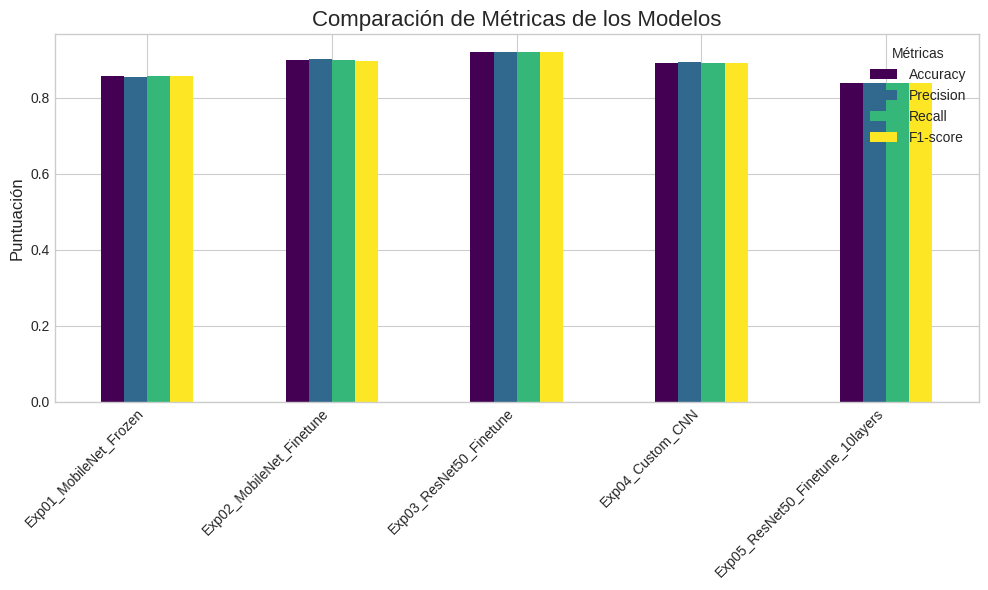

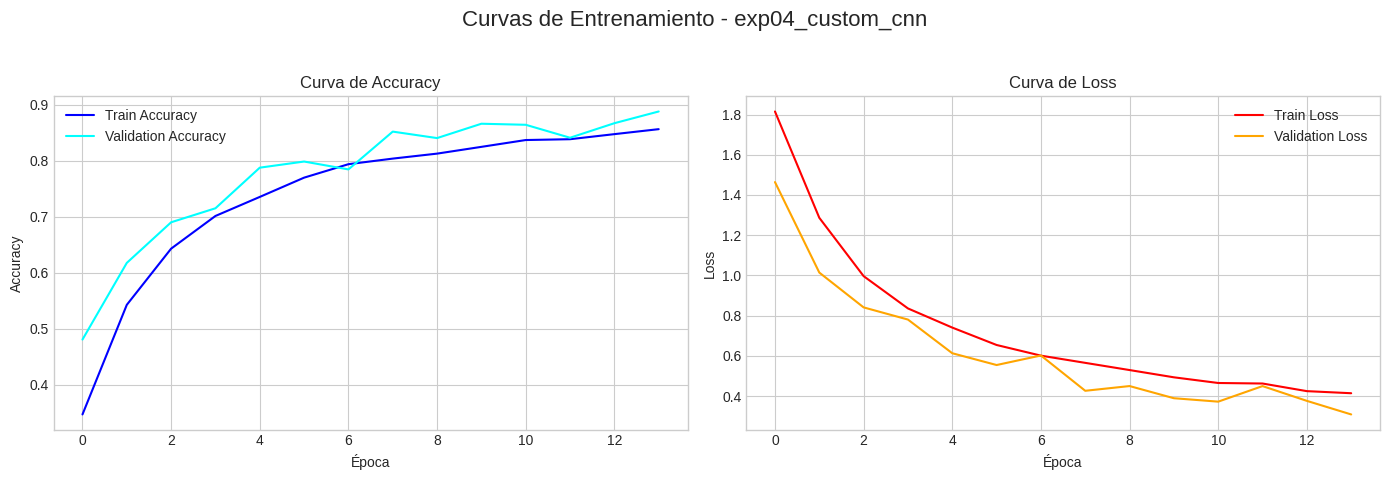

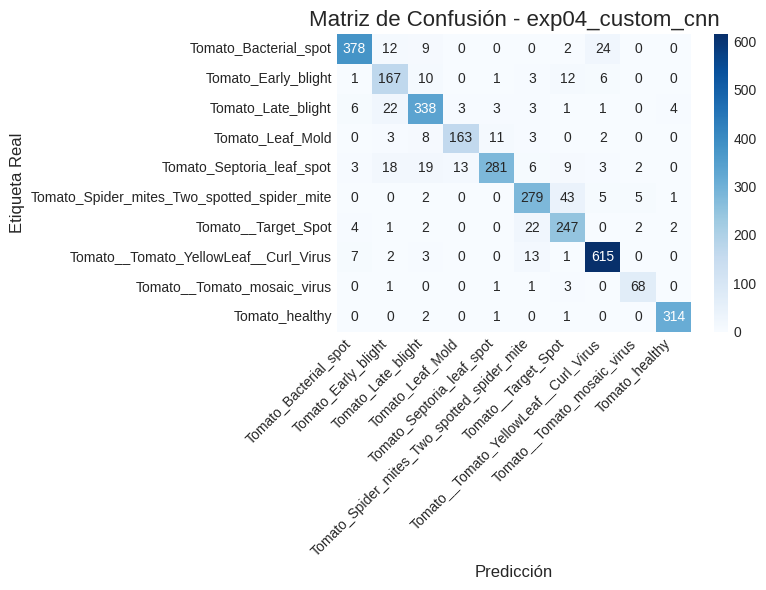

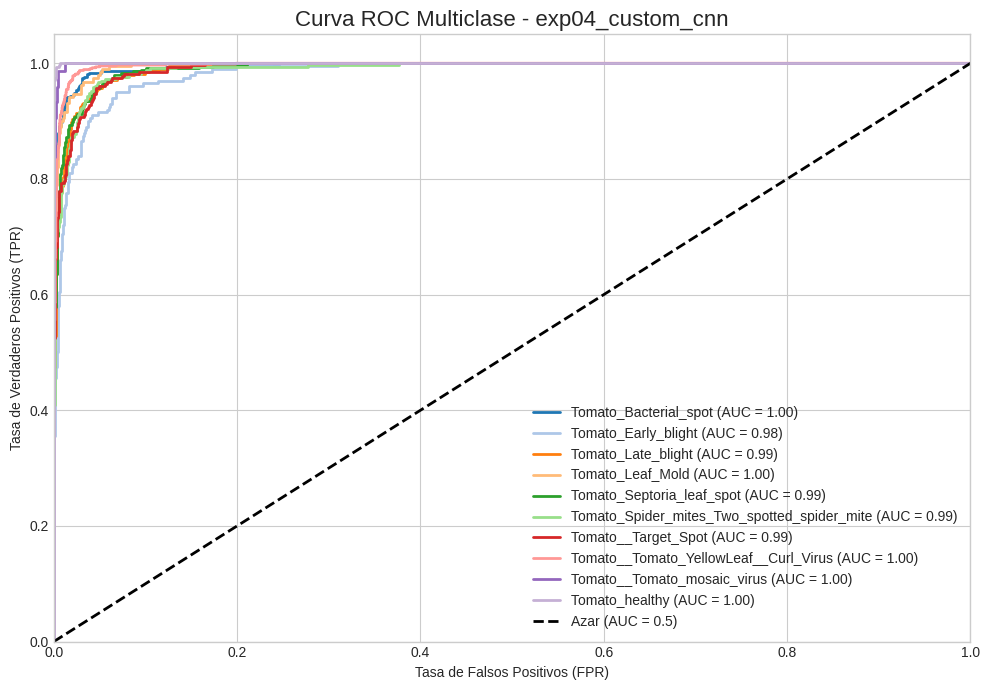


✅ Proceso de visualización completado.


In [ ]:
# 6. Visualización de Resultados y Análisis Detallado

print("Generando visualizaciones...")

# --- Cargar datos del modelo recién entrenado para los gráficos ---
best_model = load_model(model_path)
y_pred_prob = best_model.predict(val_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- 1. Gráfico de Barras Comparativo ---
plt.style.use('seaborn-v0_8-whitegrid')
# --- MODIFICACIÓN: Reducir el tamaño de la figura ---
results_df.set_index('Modelo').plot(kind='bar', figsize=(10, 6), colormap='viridis') # Ajustado figsize a (10, 6)
plt.title('Comparación de Métricas de los Modelos', fontsize=16)
plt.ylabel('Puntuación', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Métricas')
plt.tight_layout()
plt.savefig(f'{DRIVE_PROJECT_PATH}/model_comparison_bars.png', dpi=300)
plt.show()

# --- 2. Curvas de Entrenamiento del Modelo Actual (Exp 4) ---
# --- CORRECCIÓN: Usar 'final_history' en lugar de 'history.history' ---
hist_df = pd.DataFrame(final_history)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Accuracy', color='blue')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy', color='cyan')
plt.title('Curva de Accuracy'); plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss', color='red')
plt.plot(hist_df['val_loss'], label='Validation Loss', color='orange')
plt.title('Curva de Loss'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend()
plt.suptitle(f'Curvas de Entrenamiento - {EXPERIMENT_NAME}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'{DRIVE_PROJECT_PATH}/{EXPERIMENT_NAME}_curvas.png', dpi=300)
plt.show()

# --- 3. Matriz de Confusión del Modelo Actual (Exp 4) ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6)) # Reducido el tamaño de la figura
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Matriz de Confusión - {EXPERIMENT_NAME}', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{DRIVE_PROJECT_PATH}/{EXPERIMENT_NAME}_matrix.png', dpi=300)
plt.show()

# --- 4. Curva ROC Multiclase del Modelo Actual (Exp 4) ---
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7)) # Reducido el tamaño de la figura
colors = cycle(plt.cm.tab20.colors)
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)'); plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title(f'Curva ROC Multiclase - {EXPERIMENT_NAME}', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.savefig(f'{DRIVE_PROJECT_PATH}/{EXPERIMENT_NAME}_roc.png', dpi=300)
plt.show()

print("\n✅ Proceso de visualización completado.")

In [ ]:
# Celda de verificación para listar archivos en la carpeta del proyecto
import os

drive_project_path = '/content/drive/MyDrive/PROYECTO'

if os.path.exists(drive_project_path):
    print(f"Contenido de la carpeta: {drive_project_path}\n")
    files_in_drive = os.listdir(drive_project_path)
    if not files_in_drive:
        print("La carpeta está vacía.")
    else:
        for filename in sorted(files_in_drive):
            print(f"- {filename}")
else:
    print(f"❌ La carpeta no existe en la ruta especificada: {drive_project_path}")

Contenido de la carpeta: /content/drive/MyDrive/PROYECTO

-  Exp04_Custom_CNN.ipynb
- .ipynb_checkpoints
- Exp01_MobileNet_Frozen..ipynb
- Exp03_ResNet50_Finetune.ipynb
- exp01_mobilenet_frozen.keras
- exp01_mobilenet_frozen_history.pkl
- exp02_mobilenet.finetune.ipynb
- exp02_mobilenet_finetune_phase1.keras
- exp02_mobilenet_finetune_phase1_history.pkl
- exp02_mobilenet_finetune_phase2.keras
- exp02_mobilenet_finetune_phase2_history.pkl
- exp03_resnet50_finetune_phase1.keras
- exp03_resnet50_finetune_phase1_history.pkl
- exp03_resnet50_finetune_phase2.keras
- exp03_resnet50_finetune_phase2_history.pkl
- exp04_custom_cnn.keras
- exp04_custom_cnn_curvas.png
- exp04_custom_cnn_history.pkl
- exp04_custom_cnn_matrix.png
- exp04_custom_cnn_roc.png
- exp05_resnet50_finetune_10layers
- exp05_resnet50_finetune_10layers_phase1.keras
- exp05_resnet50_finetune_10layers_phase1_history.pkl
- exp05_resnet50_finetune_10layers_results
- model_comparison_bars.png
- model_comparison_results.csv


In [ ]:
import os

drive_project_path = '/content/drive/MyDrive/PROYECTO'

if os.path.exists(drive_project_path):
    print(f"Contenido de la carpeta: {drive_project_path}\n")
    files_in_drive = os.listdir(drive_project_path)
    if not files_in_drive:
        print("La carpeta está vacía.")
    else:
        for filename in sorted(files_in_drive):
            print(f"- {filename}")
else:
    print(f"❌ La carpeta no existe en la ruta especificada: {drive_project_path}")

Contenido de la carpeta: /content/drive/MyDrive/PROYECTO

-  Exp04_Custom_CNN.ipynb
- .ipynb_checkpoints
- Exp01_MobileNet_Frozen..ipynb
- Exp03_ResNet50_Finetune.ipynb
- exp01_mobilenet_frozen.keras
- exp01_mobilenet_frozen_history.pkl
- exp02_mobilenet.finetune.ipynb
- exp02_mobilenet_finetune_phase1.keras
- exp02_mobilenet_finetune_phase1_history.pkl
- exp02_mobilenet_finetune_phase2.keras
- exp02_mobilenet_finetune_phase2_history.pkl
- exp03_resnet50_finetune_phase1.keras
- exp03_resnet50_finetune_phase1_history.pkl
- exp03_resnet50_finetune_phase2.keras
- exp03_resnet50_finetune_phase2_history.pkl
- exp04_custom_cnn.keras
- exp04_custom_cnn_curvas.png
- exp04_custom_cnn_history.pkl
- exp04_custom_cnn_matrix.png
- exp04_custom_cnn_roc.png
- exp05_resnet50_finetune_10layers
- exp05_resnet50_finetune_10layers_phase1.keras
- exp05_resnet50_finetune_10layers_phase1_history.pkl
- exp05_resnet50_finetune_10layers_results
- model_comparison_bars.png
- model_comparison_results.csv
